# Flame Workflow - 07JAN21 Rough Calibration
### Assuming the calibration conversion happens after using the old calibration curve

In [1]:
import numpy as np

#
# Start timing howe long it takes to run the notebook
#
import time
start_time = time.time()

#################################
# Specify directories and files #
#################################
# indir = Directory that contains flame spectra in csv format files
# outdir = Directory where plots will be written
# calfile = Flame calibration files to convert from DN to radiance
# TelemetryFile = Telemetry/GPS data from the drone
#
inFlamedir = '../MISC/RoughCAL/FLAME/08deg/'
inSR3500dir = '../MISC/RoughCAL/SR3500/'
outdir = '../PNGS/MULLION/RoughCal-07JAN21/'
calfile = '../CALIBRATION/RadCalCoeff_GT08_.csv'
#TelemetryFile = '../MULLION/09DEC20/RAW_DATA/flight_logs/Dec-9th-2020-11-03AM-Flight-Airdata.csv'

#
# field_data contains entries relevant for particular campaign. They are:
# 0: Three letter abbreviation for field site name
# 1: Date
# 2: Comment
# 3: Name of platform
# 4: Which panel was used
# 5: Whether the data were taken in radiance or reflectance mode (not used)
# 6: Not used, but must be blank (was for USGS comparison)
# 7: Whether satellite data is collection 5 or 6 (assumed to be C5) - must NOT be blank
#
field_data = ['XXX', '07JAN21', 'RoughCal', 'Landsat8', 'GA 10inch Panel 99aa03-0319-1952', 'Radiance', '', 'C5']

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 1

In [2]:
#
# IMPORTS
#
from datetime import datetime, timedelta
import pandas as pd
import numpy as np 
import glob, os, subprocess

import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, shutil
from scipy import interpolate

#
# Add to path the directory where all the Flame-specific code resides.
#
sys.path.append("..")
from SRC import *

#
# Set up matplot lib  and notebook for plotting
#
%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams['savefig.dpi'] = 300

#
# Start labelling Figures at number 1
#
fignum=1

#
# Identify files that contain the Landsat and Sentinel band spectral response curves
#
sat_resp = dict({'Landsat5': '../../../CalVal_Phase1/SENSOR_BANDS/landsat5_vsir.flt', 
            'Landsat7': '../../../CalVal_Phase1/SENSOR_BANDS/landsat7_vsir.flt', 
            'Landsat8': '../../../CalVal_Phase1/SENSOR_BANDS/landsat8_vsir.flt',
            'Sentinel2a': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2a.flt',
            'Sentinel2b': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

### Read in Flame spectral data

In [3]:
allFlamedata = LoadData.load_from_dir(inFlamedir, calfile)

In [4]:
allFlamedata

,DN,CalData,filename,date_saved,IntTime,SpecNum
Wavelength,,,,,,
349.377,426.62,NaN,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0
349.756,461.02,NaN,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0
350.135,469.99,NaN,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0
350.514,491.51,NaN,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0
350.892,520.21,NaN,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0
...,...,...,...,...,...,...
909.732,2885.89,NaN,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9
910.033,2866.89,NaN,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9
910.334,2843.04,NaN,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9


In [5]:
from scipy import interpolate
#
# Slightly adjust wavelength in calibration file to take into new Flame calibration, post OCT 2020
#
def rejig_cal_wavelength(calfile, alldata):
    caldata = pd.read_csv(calfile)
    func = interpolate.interp1d(caldata.wl, caldata.rad_cal_mean)
    alldata['CalData'] = func(alldata.index)
    
    return alldata

allFlamedata = rejig_cal_wavelength(calfile, allFlamedata)

### Average all Flame spectra into 1nm bins

In [6]:
avgFlamedata = WavelengthBin.wavelength_bin(allFlamedata)

### Define a quick scatter plot

In [7]:
def scatter_plot(xdata, ydata):
    plt.scatter(xdata, ydata, s=3)
    plt.xlim(xdata.min(), xdata.max())
    plt.ylim(ydata.min(), ydata.max())

In [8]:
#calfile = '/g/data/up71/projects/CalVal_Phase2/FLAME/CALIBRATION/RadCalCoeff_GT08_.csv'
allSR3500data = LoadSR3500Data.load_from_dir(inSR3500dir)

In [9]:
allSR3500data

,Wavelength,Rad_Target,filename,date_saved,IntTime,Latitude,Longitude,Spec_number
0,350.0,0.001954,SR3500_panel_kfactor_10_00000.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,0
1,351.0,0.002080,SR3500_panel_kfactor_10_00000.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,0
2,352.0,0.002217,SR3500_panel_kfactor_10_00000.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,0
3,353.0,0.002351,SR3500_panel_kfactor_10_00000.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,0
4,354.0,0.002485,SR3500_panel_kfactor_10_00000.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,0
...,...,...,...,...,...,...,...,...
2146,2496.0,0.011574,SR3500_panel_kfactor_10_2_00021.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,19
2147,2497.0,0.011555,SR3500_panel_kfactor_10_2_00021.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,19
2148,2498.0,0.011539,SR3500_panel_kfactor_10_2_00021.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,19
2149,2499.0,0.011528,SR3500_panel_kfactor_10_2_00021.sed,2021-01-05 23:25:47,30.0,-35.123078,148.862505,19


In [10]:
allFlamedata['radiance'] = allFlamedata.DN*allFlamedata.CalData/allFlamedata.IntTime
allFlamedata['Line']=1


In [11]:
allSR3500data.rename(columns={'Spec_number': 'SpecNum', 'Rad_Target': 'radiance'}, inplace=True)
all_SR3500_spec = MakeSpecDF.make_spec_df(allSR3500data)

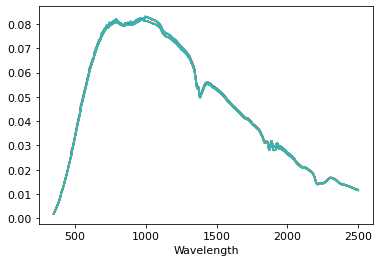

In [12]:
all_SR3500_spec.plot(legend=False)

In [13]:
allFlamedata

,DN,CalData,filename,date_saved,IntTime,SpecNum,radiance,Line
Wavelength,,,,,,,,
349.377,426.62,1.059969e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000599,1
349.756,461.02,1.042903e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000637,1
350.135,469.99,1.036231e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000645,1
350.514,491.51,1.076027e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000701,1
350.892,520.21,1.063345e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000733,1
...,...,...,...,...,...,...,...,...
909.732,2885.89,5.329456e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020377,1
910.033,2866.89,5.326054e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020229,1
910.334,2843.04,5.335948e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020098,1


In [14]:
allFlamedata.reset_index(inplace=True)

In [15]:
all_Flame_spec = MakeSpecDF.make_spec_df(allFlamedata)

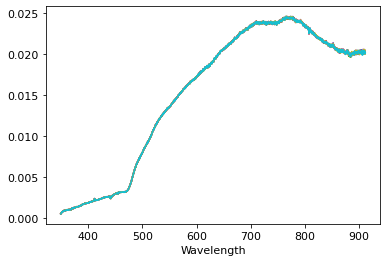

In [16]:
all_Flame_spec.plot(legend=False)

In [17]:
all_Flame_spec

,radiance,radiance-1,radiance-2,radiance-3,radiance-4,radiance-5,radiance-6,radiance-7,radiance-8,radiance-9
Wavelength,,,,,,,,,,
349.377,0.000599,0.000584,0.000578,0.000573,0.000582,0.000587,0.000607,0.000606,0.000590,0.000557
349.756,0.000637,0.000621,0.000598,0.000622,0.000607,0.000603,0.000617,0.000623,0.000634,0.000617
350.135,0.000645,0.000672,0.000639,0.000650,0.000645,0.000644,0.000661,0.000648,0.000656,0.000653
350.514,0.000701,0.000718,0.000721,0.000686,0.000705,0.000697,0.000705,0.000712,0.000712,0.000701
350.892,0.000733,0.000734,0.000741,0.000728,0.000717,0.000732,0.000713,0.000737,0.000718,0.000732
...,...,...,...,...,...,...,...,...,...,...
909.732,0.020246,0.020475,0.020536,0.020437,0.020556,0.020457,0.020587,0.020443,0.020590,0.020377
910.033,0.020323,0.020323,0.020242,0.020162,0.020199,0.020342,0.020338,0.020337,0.020362,0.020229
910.334,0.020144,0.020199,0.020147,0.020228,0.020147,0.020094,0.020126,0.020330,0.020179,0.020098


In [18]:
SR3500mean = all_SR3500_spec.mean(axis=1)
Flamemean = all_Flame_spec.mean(axis=1)

In [19]:
SR3500mean = SR3500mean.append(pd.Series({349.0: 0.001862})).sort_index()

In [20]:
func = interpolate.interp1d(SR3500mean.index, SR3500mean.values)

In [21]:
plop = pd.DataFrame(Flamemean)

In [22]:
plop['SR3500'] = func(plop.index)

In [23]:
plop.columns=['Flame', 'SR3500']

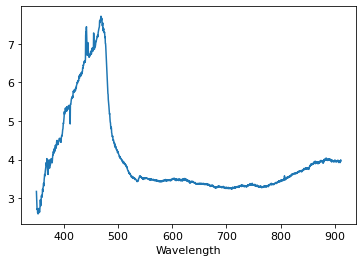

In [24]:
(plop.SR3500/plop.Flame).plot()

In [25]:
(plop.SR3500/plop.Flame).to_csv('RoughFlameCal.csv')

In [26]:
calfac = pd.read_csv('RoughFlameCal.csv')

In [27]:
calfac.set_index('Wavelength', inplace=True)

In [28]:
plop['calfac'] = calfac['0']

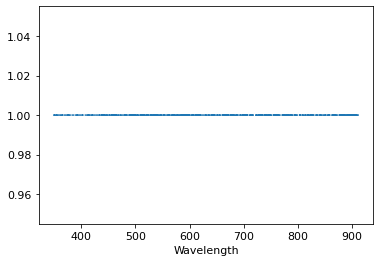

In [29]:
(plop.Flame*plop.calfac/plop.SR3500).plot()

In [30]:
allFlamedata

,Wavelength,DN,CalData,filename,date_saved,IntTime,SpecNum,radiance,Line
0,349.377,426.62,1.059969e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000599,1
1,349.756,461.02,1.042903e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000637,1
2,350.135,469.99,1.036231e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000645,1
3,350.514,491.51,1.076027e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000701,1
4,350.892,520.21,1.063345e-07,flame_panel_kfactor_8deg_FLMS150811__0__00-54-...,2021-01-05 00:54:50.030,0.07548,0,0.000733,1
...,...,...,...,...,...,...,...,...,...
16425,909.732,2885.89,5.329456e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020377,1
16426,910.033,2866.89,5.326054e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020229,1
16427,910.334,2843.04,5.335948e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020098,1
16428,910.635,2846.63,5.382855e-07,flame_panel_kfactor_8deg_FLMS150811__9__00-55-...,2021-01-05 00:55:06.999,0.07548,9,0.020301,1
